In [36]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
stop_words = list(stop_words.ENGLISH_STOP_WORDS) + list(punctuation)

In [2]:
hparams = {
    'n_features' : 10000
}

### 20newgroups

In [17]:
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')

train_data, val_data = train_test_split(list(zip(train.data, train.target)), test_size=0.1, random_state=0)
train_texts, train_targets = zip(*train_data)
val_texts, val_targets = zip(*val_data)

tfidf = TfidfVectorizer(max_features=hparams['n_features'], stop_words=stop_words)
train_features = tfidf.fit_transform(train_texts).toarray().astype(np.float32)
val_features = tfidf.transform(val_texts).toarray().astype(np.float32)
test_features = tfidf.transform(test.data).toarray().astype(np.float32)

class_counts = Counter(train_targets)
class_weights = np.array([max(class_counts.values())/class_counts[i] for i in range(len(class_counts))])

label_dict = dict([(k, v) for k, v in enumerate(train.target_names)])

### CIFAR-100

In [79]:
import subprocess
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

class Cifar100:
    def __init__(self):
        if not os.path.exists('cifar-100-python'):
            if not os.path.exists('cifar-100-python.tar.gz'):
                process = subprocess.Popen('wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'.split(), stdout=subprocess.PIPE)
                output, error = process.communicate()
                if error: print(error)
            process = subprocess.Popen('tar -zxf cifar-100-python.tar.gz'.split(), stdout=subprocess.PIPE)
            output, error = process.communicate()
            if error: print(error)
    
        cifar_meta = unpickle('cifar-100-python/meta')
        cifar_train = unpickle('cifar-100-python/train')
        cifar_test = unpickle('cifar-100-python/test')

In [80]:
cifar100 = Cifar100()

In [13]:
cifar_meta = unpickle('cifar-100-python/meta')
cifar_train = unpickle('cifar-100-python/train')
cifar_test = unpickle('cifar-100-python/test')

In [90]:
train_flat_labels, train_hier_labels = [], []
for coarse_label, fine_label in zip(cifar_train[b'coarse_labels'], cifar_train[b'fine_labels']):
    train_flat_labels.append(fine_label)
    train_hier_labels.append((coarse_label, fine_label))

In [103]:
unique_hier_labels = sorted(set(train_hier_labels), key=lambda x : x[1])

In [113]:
cifar_meta['coarse_label_names'] = [x.decode('utf8') for x in cifar_meta[b'coarse_label_names']]
cifar_meta['fine_label_names'] = [x.decode('utf8') for x in cifar_meta[b'fine_label_names']]

In [114]:
flat_label_dict = dict([(y, cifar_meta['coarse_label_names'][x] + '.' + cifar_meta['fine_label_names'][y]) for x, y in unique_hier_labels])

In [115]:
hier_label_dict = [dict(enumerate(cifar_meta['coarse_label_names'])), dict(enumerate(cifar_meta['fine_label_names']))]

In [19]:
cifar_train[b'data'].shape

(50000, 3072)

In [25]:
img = cifar_train[b'data'][0]

In [39]:
train_images = []
for arr in cifar_train[b'data']:
    img = np.zeros((32, 32, 3), dtype=np.uint8)
    img[..., 0] = np.reshape(arr[:1024], (32, 32))
    img[..., 1] = np.reshape(arr[1024:2048], (32, 32))
    img[..., 2] = np.reshape(arr[2048:], (32, 32))
    train_images.append(img)

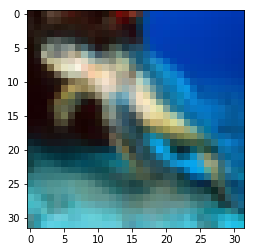

In [49]:
plt.imshow(train_images[99])

In [56]:
import torchvision.models as models
import torch

In [63]:
# resnet = models.wide_resnet50_2(pretrained=True)
resnet = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:03<00:00, 79.3MB/s] 


In [59]:
batch = np.transpose(train_images[:16], (0, 3, 1, 2))

In [64]:
resnet_vectorizer = torch.nn.Sequential(*(list(resnet.children())[:-1]))

In [67]:
resnet_vectorizer(torch.tensor(batch, dtype=torch.float32)).shape

torch.Size([16, 2048, 1, 1])

### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
clf = LogisticRegression(class_weight='balanced')

In [20]:
clf.fit(train_features, train_targets)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [21]:
clf.score(train_features, train_targets)

0.9643133355430339

In [22]:
clf.score(val_features, val_targets)

0.8824569155987627

In [23]:
clf.score(test_features, test.target)

0.8068242166755177